## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

## And so on and so forth...

In [1]:
from camera_calibrate import CameraCalibration
import glob
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from color_thresh import hls_select
from color_thresh import rgb_select
from gradient_thresh import abs_sobel_thresh
from gradient_thresh import magnitude_thresh
from gradient_thresh import direction_threshold
from bird_eye import bird_eye_view
from bird_eye import second_bird_eye_view

%matplotlib inline

In [2]:
images = glob.glob('../camera_cal/calibration*.jpg')
cal = CameraCalibration(images)

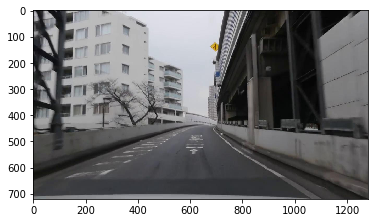

In [40]:
# img = mpimg.imread('../test_images/test5.jpg')
# img = mpimg.imread('../test_images/straight_lines1.jpg')
img = mpimg.imread('frame.jpeg')

plt.imshow(img)
plt.show()

# img = cal(img)

# plt.imshow(img)
# plt.show()

In [ ]:
# # Apply each of the thresholding functions
# gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(40, 100))
# grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(40, 100))
# mag_binary = magnitude_thresh(img, sobel_kernel=9, thresh=(30, 100))
# dir_binary = direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

# combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) | (mag_binary == 1) & (dir_binary == 1))] = 1
# plt.imshow(combined, cmap='gray');

In [ ]:
# img = mpimg.imread('../test_images/straight_lines2.jpg')
# # img = mpimg.imread('../test_images/test5.jpg')
# img = cal(img)

# r_binary = rgb_select(img, channel='R', thresh=(215, 255), debug=False)
# # r_binary = rgb_select(img, channel='R', thresh=(215, 255), debug=True)
# s_binary = hls_select(img, thresh=(70, 235), debug=False)
# # s_binary = hls_select(img, thresh=(70, 235), debug=True)
# gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 150), debug=False)
# # gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 150), debug=True)
# h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=False)
# # h_binary = hls_select(img, channel='h', thresh=(17, 70), debug=True)

# combined_binary = np.zeros_like(gradx_binary)
# combined_binary[(gradx_binary == 1) | (((h_binary == 1) & (s_binary == 1)) | (r_binary == 1))] = 1

In [41]:
def perspective_transform(img, camera_offset=0, helf_of_lane_width=50, debug=False):
    # Get image dimensions
    
        
    (h, w) = (img.shape[0], img.shape[1])
    
    roi_y_top = h*0.625
    mid_x = w//2         # midden position of x coordinate in the given image

#     dst_w_offset = 300
    
    src_vertices = np.array([[mid_x + helf_of_lane_width + camera_offset, roi_y_top], [w + 100 + camera_offset, h], [-100 + camera_offset, h], [mid_x - helf_of_lane_width + camera_offset, roi_y_top]], dtype=np.int32)
    # Define corresponding destination points
    dst_vertices = np.array([[w - 100 + camera_offset, 0], [w - 100 + camera_offset, h], [100 + camera_offset, h], [100 + camera_offset, 0]], dtype=np.int32)
    
#     src_vertices = np.array([[mid_x + offset, roi_y_top], [w - 160, h], 
#                              [200, h], [mid_x - offset, roi_y_top]], dtype=np.int32)
#     dst_vertices = np.array([[w - dst_w_offset, 0], [w - dst_w_offset, h], 
#                              [dst_w_offset, h]    , [dst_w_offset, 0]], dtype=np.int32)
        
    src = np.float32(src_vertices)
    dst = np.float32(dst_vertices)
    
    # perspective transform is a matrix that's returned by the function
    # getPerspectiveTranform
    M = cv2.getPerspectiveTransform(src, dst)
    
    img_size = (img.shape[1], img.shape[0])
    
    # Apply the transform M to the original image to get the wraped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if debug == True:
        # original img with line
        if img.ndim == 2:
            channel = np.uint8(255*img)
            img_with_lines = np.dstack((channel, channel, channel))
        else:
            img_with_lines = img.copy()
            
        pts = src_vertices.reshape((-1,1,2))
        lines = cv2.polylines(img_with_lines, [pts], True, (255,0,0), thickness=3)
        plt.title('img_with_lines')
        plt.imshow(img_with_lines)
        plt.show()
        
        # flat bird-eye img with line
        if img.ndim == 2:
            channel = np.uint8(255*warped)
            flat_bird_eye_img_with_lines = np.dstack((channel, channel, channel))
        else:
            flat_bird_eye_img_with_lines = warped.copy()
        pts = dst_vertices.reshape((-1,1,2))
        lines = cv2.polylines(flat_bird_eye_img_with_lines, [pts], True, (255,0,0), thickness=3)
        plt.title('flat_bird_eye_img_with_lines')
        plt.imshow(flat_bird_eye_img_with_lines)
        plt.show()

    return warped, M

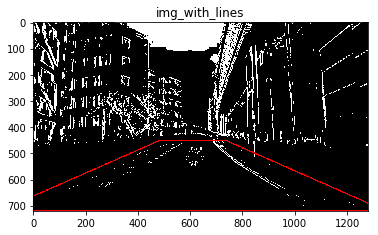

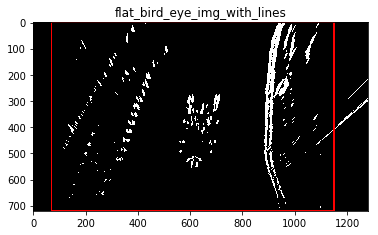

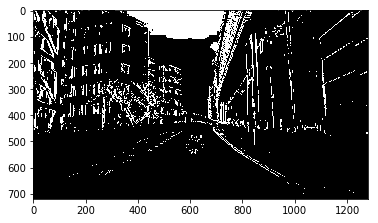

In [54]:
r_binary = rgb_select(img, channel='R', thresh=(215, 255), debug=False)
s_binary = hls_select(img, thresh=(70, 235), debug=False)
gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 150), debug=False)
h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=False)

combined_binary = np.zeros_like(gradx_binary)
combined_binary[(gradx_binary == 1) | (((h_binary == 1) & (s_binary == 1)) | (r_binary == 1))] = 1

bird_eye_binary, M = perspective_transform(combined_binary, camera_offset=-30, helf_of_lane_width=125, debug=True)
# bird_eye_binary, M = perspective_transform(combined_binary, debug=True)

out_img, _, _ = bird_eye_view(bird_eye_binary, M, img)

plt.imshow(combined_binary, cmap='gray')


In [74]:
def static_var(varname, value):
    def decorate(func):
        setattr(func, varname, value)
        return func
    return decorate

@static_var("counter", 0)
@static_var("left_fit", None)
@static_var("right_fit", None)
def pipeline(img):
    pipeline.counter += 1
#     img = cal(img)
    
    r_binary = rgb_select(img, channel='R', thresh=(215, 255), debug=False)
    s_binary = hls_select(img, thresh=(70, 235), debug=False)
    gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 150), debug=False)
    h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=False)
    
    combined_binary = np.zeros_like(gradx_binary)
    combined_binary[(gradx_binary == 1) | (((h_binary == 1) & (s_binary == 1)) | (r_binary == 1))] = 1
    out_img = np.dstack((combined_binary, combined_binary, combined_binary)) * 255
    
    
#     bird_eye_binary, M = perspective_transform(combined_binary, camera_offset=-30, helf_of_lane_width=125 , debug=False)

#     bird_eye_binary, M = perspective_transform(combined_binary, debug=False)
#     if pipeline.counter == 1:
#     out_img, pipeline.left_fit, pipeline.right_fit = bird_eye_view(bird_eye_binary, M, img, debug=True)
#     else:
#         out_img, pipeline.left_fit, pipeline.right_fit = second_bird_eye_view(bird_eye_binary, 
#                                                 pipeline.left_fit, pipeline.right_fit, M, img, debug=True)
    return out_img.astype(np.uint8)

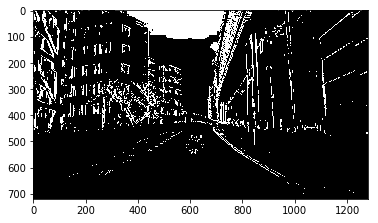

In [75]:
out_img = pipeline(img);
plt.imshow(out_img)

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
challenge_output = '../test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip1 = VideoFileClip('../test_videos/challenge.mp4').subclip(0,1)
challenge_clip = clip1.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [77]:
challenge_output = '../test_videos_output/4K.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip1 = VideoFileClip('../test_videos/4K.mp4').subclip(405,410)
clip1 = VideoFileClip('../test_videos/4K.mp4').subclip(80,85)
# clip1 = VideoFileClip('../test_videos/4K.mp4').subclip(25,27)
# clip1.save_frame("frame.jpeg", t=25)
challenge_clip = clip1.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video ../test_videos_output/4K.mp4
[MoviePy] Writing video ../test_videos_output/4K.mp4



100%|██████████| 300/300 [00:19<00:00, 15.03it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/4K.mp4 

CPU times: user 14.9 s, sys: 3.3 s, total: 18.2 s
Wall time: 21.9 s


In [ ]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(10, 100))
mag_binary = magnitude_thresh(img, sobel_kernel=9, thresh=(30, 100))
dir_binary = direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) | (mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray');

In [ ]:
bird_eye_binary, M = perspective_transform(combined_binary, debug=True)

In [ ]:
r_binary = rgb_select(img, channel='R', thresh=(180, 255))
# s_binary = hls_select(img, thresh=(90, 255), debug=True)
gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10, 150))

combined_binary = np.zeros_like(gradx_binary)
combined_binary[(gradx_binary == 1) | (r_binary == 1)] = 1
plt.imshow(combined_binary, cmap='gray')

In [ ]:
bird_eye_binary, M = perspective_transform(combined_binary, debug=False)

In [ ]:
out_img = bird_eye_view(bird_eye_binary, M, img, debug=True)

In [ ]:
class line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits 

In [ ]:
# Warp the detected lane boundaries back onto the original image.
# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.